In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input, layers
from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from spektral.layers import GCNConv

import keras_tuner as kt
from BaselinePrerocess import gcn_process
from graph import graph_topology
from baselines.gcn import gcn

2023-07-22 16:58:31.524113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 16:58:33.037310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Parameters

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5


# ===== model parameters ======
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
dropout = 0
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = gcn_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 14, 96) (9634, 14, 96) (19268, 14, 96) (77069, 96) (9634, 96) (19268, 96)


### Graph topology

In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [ 0  0  0  0  0  1  1  1  2  2  2  3  3  4  4  4  4  5  5  5  6  6  6  7
  7  7  8  8  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 12 13 13 13 13
 13 13 13 13 13 13 13 13 13 13] 
neighbor_indices: [ 1  4  8 12 13  1  4 13  3  4 13  2 13  0  1  2 13  7  8 13  7  8 13  5
  6 13  0  5  6 12 13 11 12 13 11 12 13  9 10 13  0  9 10 13  0  1  2  3
  4  5  6  7  8  9 10 11 12 13]
number of nodes: 14, number of edges: 58


In [7]:
print(train_adj_mat.shape, val_adj_mat.shape, test_adj_mat.shape)

(77069, 14, 14) (9634, 14, 14) (19268, 14, 14)


### Model

In [8]:
n_nodes = train_adj_mat.shape[-1]
n_timesteps = train_X_mask.shape[-1]

In [9]:
# n_nodes, n_timesteps, gcn1, gcn2, lstm_unit
model, GCNConv = gcn(gcn1=gcn_unit1,
                     gcn2=gcn_unit2,
                     n_nodes=n_nodes,
                     n_timesteps=n_timesteps,
                     lstm_unit=lstm_units,
                     dropout=dropout,
                     masked_value=masked_value
                    )
model.summary()

2023-07-22 00:47:32.209984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 14, 96)]             0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 14, 14)]             0         []                            
                                                                                                  
 gcn_conv (GCNConv)          (None, 14, 32)               3104      ['input_2[0][0]',             
                                                                     'input_1[0][0]']             
                                                                                                  
 gcn_conv_1 (GCNConv)        (None, 14, 16)               528       ['gcn_conv[0][0]',        

In [9]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/gcn_gate_pump.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'GCNConv': GCNConv},
                     save_best_only=True
                    )


model.fit([train_X_mask, train_adj_mat], train_ws_y,
          validation_data=([test_X_mask, test_adj_mat], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-21 10:54:29.474521: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f12a801b030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-21 10:54:29.474572: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-21 10:54:29.484991: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-21 10:54:29.718349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-21 10:54:30.108217: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.08080, saving model to saved_models/gcn_gate_pump.h5
151/151 - 8s - loss: 0.0758 - mae: 0.1489 - val_loss: 0.0108 - val_mae: 0.0808 - 8s/epoch - 56ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.08080 to 0.06462, saving model to saved_models/gcn_gate_pump.h5
151/151 - 3s - loss: 0.0043 - mae: 0.0498 - val_loss: 0.0068 - val_mae: 0.0646 - 3s/epoch - 23ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.06462 to 0.05840, saving model to saved_models/gcn_gate_pump.h5
151/151 - 3s - loss: 0.0030 - mae: 0.0415 - val_loss: 0.0055 - val_mae: 0.0584 - 3s/epoch - 23ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.05840 to 0.05396, saving model to saved_models/gcn_gate_pump.h5
151/151 - 3s - loss: 0.0024 - mae: 0.0374 - val_loss: 0.0046 - val_mae: 0.0540 - 3s/epoch - 22ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.05396 to 0.05162, saving model to saved_models/gcn_gate_pump.h5
151/151 - 4s - loss: 0.0021 - mae: 0.0347 - val_loss: 0.0042 - val_mae: 0.0516 - 4s/epoch - 23ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.05162 to 0.04956, saving model to saved_models/gcn_gate_pump.h5
151/151 - 3s - loss: 0.0018 - mae: 0.0326 - val_lo

151/151 - 3s - loss: 3.5318e-04 - mae: 0.0131 - val_loss: 0.0014 - val_mae: 0.0299 - 3s/epoch - 22ms/step
Epoch 44/3000

Epoch 44: val_mae improved from 0.02870 to 0.02824, saving model to saved_models/gcn_gate_pump.h5
151/151 - 3s - loss: 3.4489e-04 - mae: 0.0129 - val_loss: 0.0013 - val_mae: 0.0282 - 3s/epoch - 22ms/step
Epoch 45/3000

Epoch 45: val_mae did not improve from 0.02824
151/151 - 3s - loss: 3.3644e-04 - mae: 0.0127 - val_loss: 0.0015 - val_mae: 0.0304 - 3s/epoch - 21ms/step
Epoch 46/3000

Epoch 46: val_mae did not improve from 0.02824
151/151 - 3s - loss: 3.2920e-04 - mae: 0.0126 - val_loss: 0.0016 - val_mae: 0.0313 - 3s/epoch - 22ms/step
Epoch 47/3000

Epoch 47: val_mae did not improve from 0.02824
151/151 - 3s - loss: 3.2293e-04 - mae: 0.0124 - val_loss: 0.0016 - val_mae: 0.0317 - 3s/epoch - 22ms/step
Epoch 48/3000

Epoch 48: val_mae did not improve from 0.02824
151/151 - 3s - loss: 3.1592e-04 - mae: 0.0123 - val_loss: 0.0016 - val_mae: 0.0319 - 3s/epoch - 22ms/step
Epo

151/151 - 4s - loss: 1.9891e-04 - mae: 0.0092 - val_loss: 0.0010 - val_mae: 0.0249 - 4s/epoch - 24ms/step
Epoch 91/3000

Epoch 91: val_mae did not improve from 0.02490
151/151 - 4s - loss: 1.9770e-04 - mae: 0.0092 - val_loss: 0.0010 - val_mae: 0.0254 - 4s/epoch - 24ms/step
Epoch 92/3000

Epoch 92: val_mae did not improve from 0.02490
151/151 - 4s - loss: 1.9688e-04 - mae: 0.0092 - val_loss: 0.0010 - val_mae: 0.0252 - 4s/epoch - 23ms/step
Epoch 93/3000

Epoch 93: val_mae improved from 0.02490 to 0.02464, saving model to saved_models/gcn_gate_pump.h5
151/151 - 4s - loss: 1.9563e-04 - mae: 0.0091 - val_loss: 9.8788e-04 - val_mae: 0.0246 - 4s/epoch - 24ms/step
Epoch 94/3000

Epoch 94: val_mae did not improve from 0.02464
151/151 - 3s - loss: 1.9401e-04 - mae: 0.0091 - val_loss: 0.0010 - val_mae: 0.0248 - 3s/epoch - 23ms/step
Epoch 95/3000

Epoch 95: val_mae improved from 0.02464 to 0.02392, saving model to saved_models/gcn_gate_pump.h5
151/151 - 4s - loss: 1.9357e-04 - mae: 0.0091 - val_lo

Epoch 134/3000

Epoch 134: val_mae did not improve from 0.01794
151/151 - 3s - loss: 1.6351e-04 - mae: 0.0081 - val_loss: 6.0029e-04 - val_mae: 0.0186 - 3s/epoch - 23ms/step
Epoch 135/3000

Epoch 135: val_mae did not improve from 0.01794
151/151 - 3s - loss: 1.6363e-04 - mae: 0.0081 - val_loss: 6.1148e-04 - val_mae: 0.0188 - 3s/epoch - 23ms/step
Epoch 136/3000

Epoch 136: val_mae did not improve from 0.01794
151/151 - 3s - loss: 1.6350e-04 - mae: 0.0081 - val_loss: 5.7963e-04 - val_mae: 0.0182 - 3s/epoch - 22ms/step
Epoch 137/3000

Epoch 137: val_mae did not improve from 0.01794
151/151 - 3s - loss: 1.6198e-04 - mae: 0.0081 - val_loss: 5.7245e-04 - val_mae: 0.0180 - 3s/epoch - 23ms/step
Epoch 138/3000

Epoch 138: val_mae improved from 0.01794 to 0.01778, saving model to saved_models/gcn_gate_pump.h5
151/151 - 3s - loss: 1.6215e-04 - mae: 0.0081 - val_loss: 5.5064e-04 - val_mae: 0.0178 - 3s/epoch - 23ms/step
Epoch 139/3000

Epoch 139: val_mae did not improve from 0.01778
151/151 - 3s - 

Epoch 178/3000

Epoch 178: val_mae did not improve from 0.01596
151/151 - 3s - loss: 1.4834e-04 - mae: 0.0077 - val_loss: 5.1610e-04 - val_mae: 0.0170 - 3s/epoch - 23ms/step
Epoch 179/3000

Epoch 179: val_mae did not improve from 0.01596
151/151 - 4s - loss: 1.4838e-04 - mae: 0.0077 - val_loss: 4.6386e-04 - val_mae: 0.0160 - 4s/epoch - 23ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.01596
151/151 - 4s - loss: 1.4730e-04 - mae: 0.0076 - val_loss: 4.7829e-04 - val_mae: 0.0164 - 4s/epoch - 23ms/step
Epoch 181/3000

Epoch 181: val_mae did not improve from 0.01596
151/151 - 3s - loss: 1.4745e-04 - mae: 0.0076 - val_loss: 4.9891e-04 - val_mae: 0.0167 - 3s/epoch - 23ms/step
Epoch 182/3000

Epoch 182: val_mae did not improve from 0.01596
151/151 - 3s - loss: 1.4724e-04 - mae: 0.0076 - val_loss: 4.6341e-04 - val_mae: 0.0160 - 3s/epoch - 23ms/step
Epoch 183/3000

Epoch 183: val_mae did not improve from 0.01596
151/151 - 3s - loss: 1.4732e-04 - mae: 0.0076 - val_loss: 4.7952e-

Epoch 224/3000

Epoch 224: val_mae did not improve from 0.01501
151/151 - 3s - loss: 1.3908e-04 - mae: 0.0074 - val_loss: 4.1952e-04 - val_mae: 0.0153 - 3s/epoch - 23ms/step
Epoch 225/3000

Epoch 225: val_mae did not improve from 0.01501
151/151 - 4s - loss: 1.3843e-04 - mae: 0.0073 - val_loss: 4.3989e-04 - val_mae: 0.0156 - 4s/epoch - 23ms/step
Epoch 226/3000

Epoch 226: val_mae did not improve from 0.01501
151/151 - 3s - loss: 1.3743e-04 - mae: 0.0073 - val_loss: 4.3398e-04 - val_mae: 0.0155 - 3s/epoch - 23ms/step
Epoch 227/3000

Epoch 227: val_mae did not improve from 0.01501
151/151 - 3s - loss: 1.3797e-04 - mae: 0.0073 - val_loss: 4.8433e-04 - val_mae: 0.0165 - 3s/epoch - 23ms/step
Epoch 228/3000

Epoch 228: val_mae did not improve from 0.01501
151/151 - 3s - loss: 1.3840e-04 - mae: 0.0073 - val_loss: 4.2251e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 229/3000

Epoch 229: val_mae did not improve from 0.01501
151/151 - 3s - loss: 1.3730e-04 - mae: 0.0073 - val_loss: 4.3220e-

Epoch 271/3000

Epoch 271: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.3177e-04 - mae: 0.0071 - val_loss: 4.0169e-04 - val_mae: 0.0149 - 3s/epoch - 23ms/step
Epoch 272/3000

Epoch 272: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.3150e-04 - mae: 0.0071 - val_loss: 4.1882e-04 - val_mae: 0.0153 - 3s/epoch - 21ms/step
Epoch 273/3000

Epoch 273: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.3187e-04 - mae: 0.0071 - val_loss: 4.7379e-04 - val_mae: 0.0163 - 3s/epoch - 22ms/step
Epoch 274/3000

Epoch 274: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.3159e-04 - mae: 0.0071 - val_loss: 4.2843e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 275/3000

Epoch 275: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.3109e-04 - mae: 0.0071 - val_loss: 4.5295e-04 - val_mae: 0.0159 - 3s/epoch - 22ms/step
Epoch 276/3000

Epoch 276: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.3168e-04 - mae: 0.0071 - val_loss: 4.4374e-


Epoch 318: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.2671e-04 - mae: 0.0069 - val_loss: 4.2211e-04 - val_mae: 0.0154 - 3s/epoch - 23ms/step
Epoch 319/3000

Epoch 319: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.2689e-04 - mae: 0.0070 - val_loss: 4.2306e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 320/3000

Epoch 320: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.2632e-04 - mae: 0.0069 - val_loss: 4.4874e-04 - val_mae: 0.0159 - 3s/epoch - 23ms/step
Epoch 321/3000

Epoch 321: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.2638e-04 - mae: 0.0069 - val_loss: 4.0204e-04 - val_mae: 0.0149 - 3s/epoch - 21ms/step
Epoch 322/3000

Epoch 322: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.2678e-04 - mae: 0.0070 - val_loss: 4.3755e-04 - val_mae: 0.0156 - 3s/epoch - 22ms/step
Epoch 323/3000

Epoch 323: val_mae did not improve from 0.01485
151/151 - 3s - loss: 1.2638e-04 - mae: 0.0069 - val_loss: 4.4101e-04 - val_mae: 0

151/151 - 3s - loss: 1.2281e-04 - mae: 0.0068 - val_loss: 3.9627e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 366/3000

Epoch 366: val_mae did not improve from 0.01475
151/151 - 3s - loss: 1.2292e-04 - mae: 0.0068 - val_loss: 4.4782e-04 - val_mae: 0.0161 - 3s/epoch - 22ms/step
Epoch 367/3000

Epoch 367: val_mae did not improve from 0.01475
151/151 - 3s - loss: 1.2303e-04 - mae: 0.0068 - val_loss: 4.4609e-04 - val_mae: 0.0158 - 3s/epoch - 22ms/step
Epoch 368/3000

Epoch 368: val_mae did not improve from 0.01475
151/151 - 3s - loss: 1.2308e-04 - mae: 0.0068 - val_loss: 4.3127e-04 - val_mae: 0.0155 - 3s/epoch - 22ms/step
Epoch 369/3000

Epoch 369: val_mae did not improve from 0.01475
151/151 - 3s - loss: 1.2261e-04 - mae: 0.0068 - val_loss: 4.2382e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 370/3000

Epoch 370: val_mae did not improve from 0.01475
151/151 - 3s - loss: 1.2265e-04 - mae: 0.0068 - val_loss: 3.9888e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 371/3000

Epoc

151/151 - 3s - loss: 1.1968e-04 - mae: 0.0067 - val_loss: 4.1379e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 413/3000

Epoch 413: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1966e-04 - mae: 0.0067 - val_loss: 4.1675e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 414/3000

Epoch 414: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1970e-04 - mae: 0.0067 - val_loss: 4.6420e-04 - val_mae: 0.0161 - 3s/epoch - 23ms/step
Epoch 415/3000

Epoch 415: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1970e-04 - mae: 0.0067 - val_loss: 4.0657e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 416/3000

Epoch 416: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1970e-04 - mae: 0.0067 - val_loss: 3.9964e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 417/3000

Epoch 417: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.2026e-04 - mae: 0.0067 - val_loss: 4.0959e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 418/3000

Epoc

Epoch 460/3000

Epoch 460: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1721e-04 - mae: 0.0066 - val_loss: 4.0712e-04 - val_mae: 0.0151 - 3s/epoch - 21ms/step
Epoch 461/3000

Epoch 461: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1726e-04 - mae: 0.0066 - val_loss: 4.2006e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 462/3000

Epoch 462: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1722e-04 - mae: 0.0066 - val_loss: 4.1357e-04 - val_mae: 0.0150 - 3s/epoch - 21ms/step
Epoch 463/3000

Epoch 463: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1722e-04 - mae: 0.0066 - val_loss: 4.3392e-04 - val_mae: 0.0155 - 3s/epoch - 22ms/step
Epoch 464/3000

Epoch 464: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1724e-04 - mae: 0.0066 - val_loss: 4.1236e-04 - val_mae: 0.0151 - 3s/epoch - 23ms/step
Epoch 465/3000

Epoch 465: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1766e-04 - mae: 0.0066 - val_loss: 4.6299e-


Epoch 507: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1535e-04 - mae: 0.0065 - val_loss: 4.2835e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 508/3000

Epoch 508: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1523e-04 - mae: 0.0065 - val_loss: 4.2542e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 509/3000

Epoch 509: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1498e-04 - mae: 0.0065 - val_loss: 4.2041e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 510/3000

Epoch 510: val_mae did not improve from 0.01464
151/151 - 3s - loss: 1.1520e-04 - mae: 0.0065 - val_loss: 4.2406e-04 - val_mae: 0.0153 - 3s/epoch - 21ms/step
Epoch 511/3000

Epoch 511: val_mae improved from 0.01464 to 0.01443, saving model to saved_models/gcn_gate_pump.h5
151/151 - 3s - loss: 1.1559e-04 - mae: 0.0065 - val_loss: 3.7859e-04 - val_mae: 0.0144 - 3s/epoch - 21ms/step
Epoch 512/3000

Epoch 512: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1510e-0

Epoch 554/3000

Epoch 554: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1346e-04 - mae: 0.0065 - val_loss: 4.3555e-04 - val_mae: 0.0156 - 3s/epoch - 21ms/step
Epoch 555/3000

Epoch 555: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1373e-04 - mae: 0.0065 - val_loss: 4.1789e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 556/3000

Epoch 556: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1374e-04 - mae: 0.0065 - val_loss: 4.2323e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 557/3000

Epoch 557: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1341e-04 - mae: 0.0065 - val_loss: 3.9240e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 558/3000

Epoch 558: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1326e-04 - mae: 0.0064 - val_loss: 3.9403e-04 - val_mae: 0.0147 - 3s/epoch - 23ms/step
Epoch 559/3000

Epoch 559: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1329e-04 - mae: 0.0065 - val_loss: 4.2253e-


Epoch 601: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1222e-04 - mae: 0.0064 - val_loss: 4.1197e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 602/3000

Epoch 602: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1225e-04 - mae: 0.0064 - val_loss: 4.2611e-04 - val_mae: 0.0153 - 3s/epoch - 23ms/step
Epoch 603/3000

Epoch 603: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1231e-04 - mae: 0.0064 - val_loss: 4.4251e-04 - val_mae: 0.0156 - 3s/epoch - 22ms/step
Epoch 604/3000

Epoch 604: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1260e-04 - mae: 0.0064 - val_loss: 3.8960e-04 - val_mae: 0.0146 - 3s/epoch - 21ms/step
Epoch 605/3000

Epoch 605: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1205e-04 - mae: 0.0064 - val_loss: 4.3827e-04 - val_mae: 0.0156 - 3s/epoch - 22ms/step
Epoch 606/3000

Epoch 606: val_mae did not improve from 0.01443
151/151 - 3s - loss: 1.1181e-04 - mae: 0.0064 - val_loss: 4.2279e-04 - val_mae: 0

Epoch 648/3000

Epoch 648: val_mae did not improve from 0.01439
151/151 - 3s - loss: 1.1088e-04 - mae: 0.0064 - val_loss: 4.3025e-04 - val_mae: 0.0154 - 3s/epoch - 21ms/step
Epoch 649/3000

Epoch 649: val_mae did not improve from 0.01439
151/151 - 3s - loss: 1.1068e-04 - mae: 0.0063 - val_loss: 4.2210e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 650/3000

Epoch 650: val_mae did not improve from 0.01439
151/151 - 3s - loss: 1.1064e-04 - mae: 0.0063 - val_loss: 3.9141e-04 - val_mae: 0.0147 - 3s/epoch - 21ms/step
Epoch 651/3000

Epoch 651: val_mae did not improve from 0.01439
151/151 - 3s - loss: 1.1086e-04 - mae: 0.0064 - val_loss: 3.9763e-04 - val_mae: 0.0148 - 3s/epoch - 21ms/step
Epoch 652/3000

Epoch 652: val_mae did not improve from 0.01439
151/151 - 3s - loss: 1.1084e-04 - mae: 0.0064 - val_loss: 4.3078e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 653/3000

Epoch 653: val_mae did not improve from 0.01439
151/151 - 3s - loss: 1.1034e-04 - mae: 0.0063 - val_loss: 4.2759e-

Epoch 695/3000

Epoch 695: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0968e-04 - mae: 0.0063 - val_loss: 4.3367e-04 - val_mae: 0.0153 - 3s/epoch - 21ms/step
Epoch 696/3000

Epoch 696: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0958e-04 - mae: 0.0063 - val_loss: 4.2165e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 697/3000

Epoch 697: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0950e-04 - mae: 0.0063 - val_loss: 4.2075e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 698/3000

Epoch 698: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0942e-04 - mae: 0.0063 - val_loss: 4.1528e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 699/3000

Epoch 699: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0944e-04 - mae: 0.0063 - val_loss: 4.1659e-04 - val_mae: 0.0151 - 3s/epoch - 21ms/step
Epoch 700/3000

Epoch 700: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0937e-04 - mae: 0.0063 - val_loss: 4.6860e-


Epoch 742: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0850e-04 - mae: 0.0063 - val_loss: 4.0361e-04 - val_mae: 0.0148 - 3s/epoch - 21ms/step
Epoch 743/3000

Epoch 743: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0830e-04 - mae: 0.0062 - val_loss: 4.3998e-04 - val_mae: 0.0154 - 3s/epoch - 22ms/step
Epoch 744/3000

Epoch 744: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0889e-04 - mae: 0.0063 - val_loss: 3.9646e-04 - val_mae: 0.0147 - 3s/epoch - 21ms/step
Epoch 745/3000

Epoch 745: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0843e-04 - mae: 0.0063 - val_loss: 3.8794e-04 - val_mae: 0.0146 - 3s/epoch - 22ms/step
Epoch 746/3000

Epoch 746: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0840e-04 - mae: 0.0063 - val_loss: 4.1091e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 747/3000

Epoch 747: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0817e-04 - mae: 0.0062 - val_loss: 4.2791e-04 - val_mae: 0

151/151 - 3s - loss: 1.0729e-04 - mae: 0.0062 - val_loss: 3.9050e-04 - val_mae: 0.0146 - 3s/epoch - 22ms/step
Epoch 790/3000

Epoch 790: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0769e-04 - mae: 0.0062 - val_loss: 4.4332e-04 - val_mae: 0.0155 - 3s/epoch - 23ms/step
Epoch 791/3000

Epoch 791: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0738e-04 - mae: 0.0062 - val_loss: 4.3424e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 792/3000

Epoch 792: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0737e-04 - mae: 0.0062 - val_loss: 4.0621e-04 - val_mae: 0.0148 - 3s/epoch - 23ms/step
Epoch 793/3000

Epoch 793: val_mae did not improve from 0.01420
151/151 - 4s - loss: 1.0735e-04 - mae: 0.0062 - val_loss: 4.3158e-04 - val_mae: 0.0153 - 4s/epoch - 23ms/step
Epoch 794/3000

Epoch 794: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0744e-04 - mae: 0.0062 - val_loss: 4.2092e-04 - val_mae: 0.0151 - 3s/epoch - 23ms/step
Epoch 795/3000

Epoc

Epoch 837/3000

Epoch 837: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0682e-04 - mae: 0.0062 - val_loss: 4.2386e-04 - val_mae: 0.0152 - 3s/epoch - 21ms/step
Epoch 838/3000

Epoch 838: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0665e-04 - mae: 0.0062 - val_loss: 4.1723e-04 - val_mae: 0.0151 - 3s/epoch - 21ms/step
Epoch 839/3000

Epoch 839: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0668e-04 - mae: 0.0062 - val_loss: 4.0311e-04 - val_mae: 0.0148 - 3s/epoch - 21ms/step
Epoch 840/3000

Epoch 840: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0655e-04 - mae: 0.0062 - val_loss: 4.2915e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 841/3000

Epoch 841: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0646e-04 - mae: 0.0062 - val_loss: 4.3494e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 842/3000

Epoch 842: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0682e-04 - mae: 0.0062 - val_loss: 4.1098e-


Epoch 884: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0574e-04 - mae: 0.0061 - val_loss: 4.0816e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 885/3000

Epoch 885: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0617e-04 - mae: 0.0062 - val_loss: 4.3197e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 886/3000

Epoch 886: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0581e-04 - mae: 0.0061 - val_loss: 4.0926e-04 - val_mae: 0.0149 - 3s/epoch - 23ms/step
Epoch 887/3000

Epoch 887: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0577e-04 - mae: 0.0061 - val_loss: 3.9906e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 888/3000

Epoch 888: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0569e-04 - mae: 0.0061 - val_loss: 4.1034e-04 - val_mae: 0.0149 - 3s/epoch - 21ms/step
Epoch 889/3000

Epoch 889: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0595e-04 - mae: 0.0062 - val_loss: 4.1451e-04 - val_mae: 0

151/151 - 3s - loss: 1.0517e-04 - mae: 0.0061 - val_loss: 4.1820e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 932/3000

Epoch 932: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0503e-04 - mae: 0.0061 - val_loss: 4.1056e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 933/3000

Epoch 933: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0513e-04 - mae: 0.0061 - val_loss: 3.9193e-04 - val_mae: 0.0146 - 3s/epoch - 23ms/step
Epoch 934/3000

Epoch 934: val_mae did not improve from 0.01420
151/151 - 4s - loss: 1.0506e-04 - mae: 0.0061 - val_loss: 4.0645e-04 - val_mae: 0.0148 - 4s/epoch - 23ms/step
Epoch 935/3000

Epoch 935: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0513e-04 - mae: 0.0061 - val_loss: 4.0018e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 936/3000

Epoch 936: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0495e-04 - mae: 0.0061 - val_loss: 4.0662e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 937/3000

Epoc

Epoch 979/3000

Epoch 979: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0455e-04 - mae: 0.0061 - val_loss: 4.3249e-04 - val_mae: 0.0153 - 3s/epoch - 21ms/step
Epoch 980/3000

Epoch 980: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0445e-04 - mae: 0.0061 - val_loss: 4.0572e-04 - val_mae: 0.0148 - 3s/epoch - 21ms/step
Epoch 981/3000

Epoch 981: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0471e-04 - mae: 0.0061 - val_loss: 4.1203e-04 - val_mae: 0.0149 - 3s/epoch - 21ms/step
Epoch 982/3000

Epoch 982: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0434e-04 - mae: 0.0061 - val_loss: 4.3186e-04 - val_mae: 0.0153 - 3s/epoch - 22ms/step
Epoch 983/3000

Epoch 983: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0441e-04 - mae: 0.0061 - val_loss: 4.0629e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 984/3000

Epoch 984: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0437e-04 - mae: 0.0061 - val_loss: 4.1340e-

Epoch 1026/3000

Epoch 1026: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0355e-04 - mae: 0.0061 - val_loss: 4.1520e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1027/3000

Epoch 1027: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0379e-04 - mae: 0.0061 - val_loss: 3.9693e-04 - val_mae: 0.0147 - 3s/epoch - 21ms/step
Epoch 1028/3000

Epoch 1028: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0374e-04 - mae: 0.0061 - val_loss: 4.0634e-04 - val_mae: 0.0148 - 3s/epoch - 21ms/step
Epoch 1029/3000

Epoch 1029: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0358e-04 - mae: 0.0061 - val_loss: 4.1650e-04 - val_mae: 0.0150 - 3s/epoch - 22ms/step
Epoch 1030/3000

Epoch 1030: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0382e-04 - mae: 0.0061 - val_loss: 3.7571e-04 - val_mae: 0.0143 - 3s/epoch - 22ms/step
Epoch 1031/3000

Epoch 1031: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0375e-04 - mae: 0.0061 - val_lo

Epoch 1073/3000

Epoch 1073: val_mae did not improve from 0.01420
151/151 - 4s - loss: 1.0307e-04 - mae: 0.0060 - val_loss: 3.9714e-04 - val_mae: 0.0146 - 4s/epoch - 23ms/step
Epoch 1074/3000

Epoch 1074: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0333e-04 - mae: 0.0060 - val_loss: 3.9215e-04 - val_mae: 0.0146 - 3s/epoch - 23ms/step
Epoch 1075/3000

Epoch 1075: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0321e-04 - mae: 0.0060 - val_loss: 4.2501e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 1076/3000

Epoch 1076: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0331e-04 - mae: 0.0060 - val_loss: 4.0784e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1077/3000

Epoch 1077: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0332e-04 - mae: 0.0061 - val_loss: 3.8721e-04 - val_mae: 0.0145 - 3s/epoch - 23ms/step
Epoch 1078/3000

Epoch 1078: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0307e-04 - mae: 0.0060 - val_lo

Epoch 1120/3000

Epoch 1120: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0297e-04 - mae: 0.0060 - val_loss: 4.0493e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 1121/3000

Epoch 1121: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0282e-04 - mae: 0.0060 - val_loss: 4.2533e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 1122/3000

Epoch 1122: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0264e-04 - mae: 0.0060 - val_loss: 4.0138e-04 - val_mae: 0.0147 - 3s/epoch - 22ms/step
Epoch 1123/3000

Epoch 1123: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0269e-04 - mae: 0.0060 - val_loss: 4.0657e-04 - val_mae: 0.0148 - 3s/epoch - 22ms/step
Epoch 1124/3000

Epoch 1124: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0279e-04 - mae: 0.0060 - val_loss: 3.7904e-04 - val_mae: 0.0143 - 3s/epoch - 22ms/step
Epoch 1125/3000

Epoch 1125: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0251e-04 - mae: 0.0060 - val_lo

Epoch 1167/3000

Epoch 1167: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0217e-04 - mae: 0.0060 - val_loss: 4.0310e-04 - val_mae: 0.0147 - 3s/epoch - 21ms/step
Epoch 1168/3000

Epoch 1168: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0252e-04 - mae: 0.0060 - val_loss: 4.1193e-04 - val_mae: 0.0149 - 3s/epoch - 22ms/step
Epoch 1169/3000

Epoch 1169: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0226e-04 - mae: 0.0060 - val_loss: 4.3088e-04 - val_mae: 0.0152 - 3s/epoch - 22ms/step
Epoch 1170/3000

Epoch 1170: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0211e-04 - mae: 0.0060 - val_loss: 4.3980e-04 - val_mae: 0.0154 - 3s/epoch - 21ms/step
Epoch 1171/3000

Epoch 1171: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0237e-04 - mae: 0.0060 - val_loss: 4.2295e-04 - val_mae: 0.0151 - 3s/epoch - 22ms/step
Epoch 1172/3000

Epoch 1172: val_mae did not improve from 0.01420
151/151 - 3s - loss: 1.0226e-04 - mae: 0.0060 - val_lo

### Performance

In [8]:
import time

In [9]:
saved_model = load_model('saved_models/gcn_gate_pump.h5', custom_objects={'GCNConv': GCNConv})


start_time = time.time()


yhat = saved_model.predict([test_X_mask, test_adj_mat])

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))


end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))

2023-07-22 16:58:47.471945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


603/603 [==============================] - 3s 4ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0753
RMSE = 0.1025
--- 3.8755381107330322 seconds ---


In [10]:
inv_yhat = pd.DataFrame(inv_yhat)
inv_yhat.to_csv('saved_results/gcn_inv_yhat.csv')

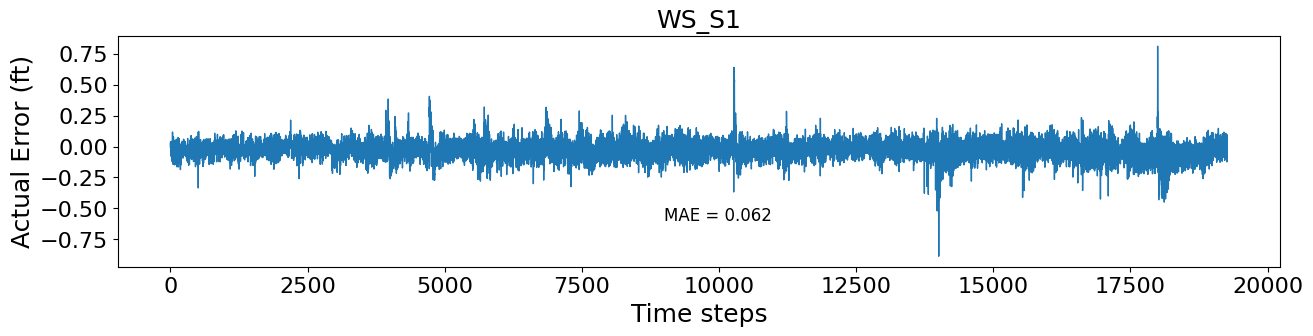

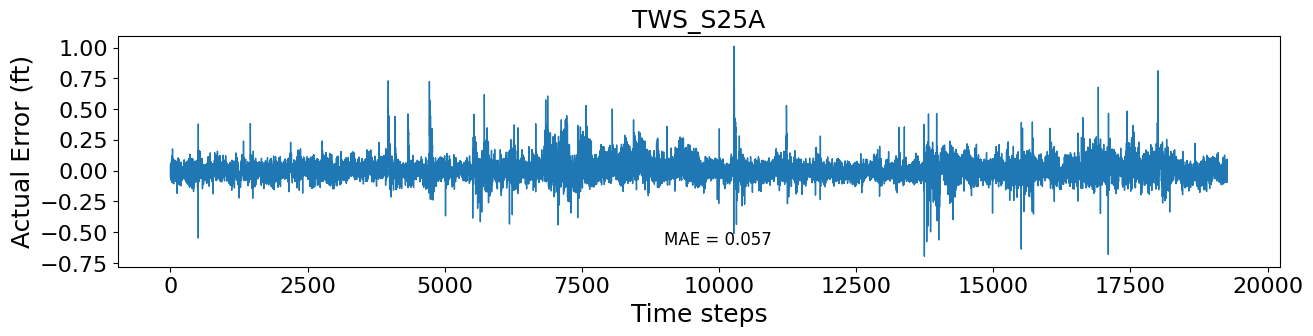

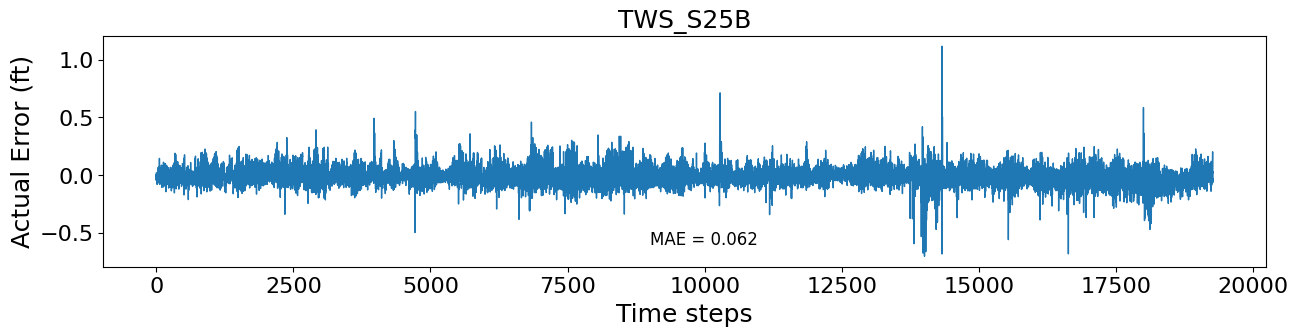

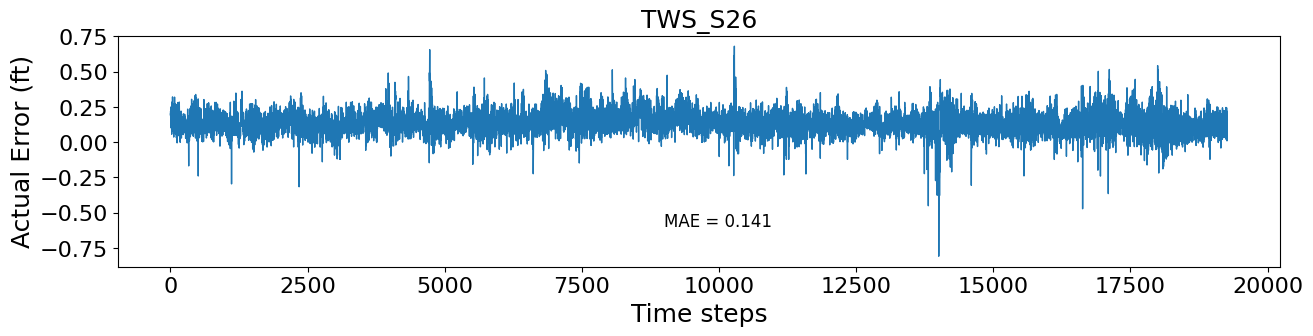

In [12]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [13]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
10
(19268,)
39
(19268,)
28
(19268,)
20


In [14]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
6
(19268,)
32
(19268,)
11
(19268,)
18


In [15]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
4
(19268,)
7
(19268,)
17
(19268,)
2
